# Прикладные задачи анализа данных

## Домашнее задание 4

В этой работе мы будем решать задачу рекомендаций музыки. Для этого мы реализуем метод коллаборативной фильтрации и модель со скрытыми переменными, сравним их между собой и попытаемся сделать выводы. Во всех заданиях разрешается переписывать код по своему усмотрению, предложенные шаблоны несут лишь рекомендательный характер.

In [1]:
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from typing import Callable, List

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as scs

In [2]:
ratings = pd.read_csv('music_dataset.csv')
ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [3]:
tracks_info = pd.read_csv('tracks_info.csv')
tracks_info.head()

,id,name,artists
0,0,What There Is,['a-ha']
1,1,I'll Play The Blues For You,['Albert King']
2,2,Breaking Up Somebody's Home,['Albert King']
3,3,Imma Be,['Black Eyed Peas']
4,4,Boom Boom Pow,['Black Eyed Peas']


Для оценки качества рекомендаций мы будем использовать метрику $MAP@k$.

$$
MAP@k = \frac{1}{N} \sum_{u = 1}^N AP_u@k
$$
$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)$$


*   $N$ - количество пользователей.
*   $n_u$ - число релевантных треков пользователя $u$ на тестовом промежутке.
*   $r_u(i)$ - бинарная величина: относится ли трек на позиции $i$ к релевантным.

**Задание 1 (1 балл).** Реализуйте метрику $MAP@k$.

In [4]:
def apk(relevant: List[int], predicted: List[int], k: int = 20):

    predicted_k = predicted[:k]
    score = 0
    true_obj = 0

    for ind, p in enumerate(predicted_k):
        if p in relevant:
            true_obj += 1
            precision_at_i = true_obj / (ind + 1)
            score += precision_at_i

    return score / min(len(relevant), k)

def mapk(relevant: List[List[int]], predicted: List[List[int]], k: int = 20):
    # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
    return sum(apk(rel, pred, k) for rel, pred in zip(relevant, predicted)) / len(relevant)

In [5]:
relevant = [
    [1, 7, 6, 2, 8],
    [1, 5, 4, 8],
    [8, 2, 5]
]

pred = [
    [8, 1, 5, 0, 7, 2, 9, 4],
    [0, 1, 8, 5, 3, 4, 7, 9],
    [9, 2, 0, 6, 8, 5, 3, 7]
]

assert round(mapk(relevant, pred, k=5), 4) == 0.4331

Разделим данные на тренировочные и тестовые так, чтобы в теcтовый датасет попали 50 последних треков каждого пользователя.

In [6]:
def train_test_split(ratings):
    train_ratings, test_ratings = [], []
    num_test_samples = 50

    # getting train samples
    for userId, user_data in tqdm(ratings.groupby('userId')):
        train_ratings += [user_data[:-num_test_samples]]

    train_ratings = pd.concat(train_ratings).reset_index(drop=True)
    all_train_items = train_ratings['trackId'].unique()

    # getting train samples
    # we drop all tracks that are not presented it the training samples,
    # because we won't be able to learn representations for them
    for userId, user_data in tqdm(ratings.groupby('userId')):
        test_items = user_data[-num_test_samples:]
        test_items = test_items[np.isin(test_items['trackId'], all_train_items)]
        test_ratings += [test_items]

    test_ratings = pd.concat(test_ratings).reset_index(drop=True)

    return train_ratings, test_ratings

In [7]:
train_ratings, test_ratings = train_test_split(ratings)

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Почистим табличку с информацией о треках и закодируем id треков так, чтобы они соответствовали их порядковому номеру.

In [8]:
redundant_rows = np.where(~np.isin(tracks_info['id'], train_ratings['trackId'].unique()))[0]
tracks_info.drop(redundant_rows, inplace=True)
tracks_info = tracks_info.reset_index(drop=True)

In [9]:
def ids_encoder(ratings):
    users = sorted(ratings['userId'].unique())
    items = sorted(ratings['trackId'].unique())

    # create users and items encoders
    uencoder = LabelEncoder()
    iencoder = LabelEncoder()

    # fit users and items ids to the corresponding encoder
    uencoder.fit(users)
    iencoder.fit(items)

    return uencoder, iencoder

In [10]:
uencoder, iencoder = ids_encoder(train_ratings)
train_ratings['trackId'] = iencoder.transform(train_ratings['trackId'].tolist())
test_ratings['trackId'] = iencoder.transform(test_ratings['trackId'].tolist())
tracks_info['id'] = iencoder.transform(tracks_info['id'].tolist())

In [11]:
train_ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [12]:
test_ratings.head()

,userId,trackId
0,0,57582
1,0,57802
2,0,57957
3,0,58174
4,0,59168


Соберем все релевантные треки для каждого пользователя в список.

In [13]:
test_relevant = []
test_users = []
for user_id, user_data in test_ratings.groupby('userId'):
    test_relevant += [user_data['trackId'].tolist()]
    test_users.append(user_id)

**Задание 2 (1 балл).** Реализуйте метод `get_test_recommendations` в классе `BaseModel`. Он принимает на вход параметр `k` и возвращает массив из `k` наиболее подходящих треков для каждого пользователя. Не забывайте удалять уже прослушанные треки из рекомендуемых.

In [14]:
class BaseModel:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))

        self.R = np.zeros((self.n_users, self.n_items))
        self.R[self.ratings['userId'], self.ratings['trackId']] = 1.

    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """
        raise NotImplementedError

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]

        return new_preds

    def get_test_recommendations(self, k: int):
        test_preds = []

        for user_id in range(self.n_users):
            preds = self.recommend(user_id)
            test_preds.append(preds)

        test_preds = self.remove_train_items(test_preds, k)

        return test_preds[test_users]
        # return test_preds

## Часть 1. Коллаборативная фильтрация (User2User)

Идея: чтобы выбрать треки, которые понравятся пользователю, можно набрать несколько похожих на него пользователей (соседей) и посмотреть, какие треки они слушают. После этого остается агрегировать треки этих пользователей и выбрать самые популярные. Соответственно, задача состоит из двух частей: выбора функции похожести двух пользователей и способа агрегации.

В качестве функции похожести мы будем использовать две метрики:

1. Корреляция Пирсона $$s(u, v) = \frac{\sum_{i \in I_u \cap I_v} r_{ui}r_{vi}}{\sqrt{\sum_{i \in I_u} r_{ui} ^2}\sqrt{\sum_{i \in I_v} r_{vi}^2}} $$

2. Мера Жаккара

$$ s(u, v) = \frac{|I_u \cap I_v|}{|I_u \cup I_v|} $$


Корреляция Пирсона немного видоизменена, чтобы подходить под нашу задачу.


Во всех формулах
* $I_u$ - множество треков, прослушанных пользователем $u$.
* $r_{ui}$ - прослушал ли пользователь $u$ трек $i$ (0 или 1).

Множество соседей определим как $$N(u) = \{ v \in U \setminus \{u\} \mid s(u, v) > \alpha\},$$ где $\alpha \, - $ гиперпараметр.



Для агрегации мы будем пользоваться следующей формулой.
$$
\hat{r}_{ui} = \frac{\sum_{v \in N(u)} s(u, v) r_{vi}}{\sum_{v \in N(u)} |s(u, v)|}
$$

**Задание 3.1 (1 балл).** Реализуйте функцию подсчета корреляции Пирсона.

**Задание 3.2 (1 балл).** Реализуйте функцию подсчета меры Жаккара.

Функции принимают матрицу оценок и вектор оценок пользователя $u$ и возвращают вектор со значениями похожести пользователя $u$ на всех пользователей. Старайтесь писать оптимизированный код, за неэффективную реализацию оценка может быть снижена.

In [15]:
def pearson(ratings: np.array, user_vector: np.array) -> np.array:
    # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
    numerator = ratings@user_vector.T

    ratings_norm = np.sqrt(np.sum(ratings**2))
    user_vector_norm = np.sqrt(np.sum(user_vector**2))

    denominator = ratings_norm*user_vector_norm

    scores = np.divide(numerator, denominator)
    scores[scores == 1] = -1
    return scores


def jaccard(ratings: np.array, user_vector: np.array) -> np.array:
    # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
    numerator = ratings@user_vector.T
    denominator = np.sum(ratings+user_vector!=0,1)

    scores = np.divide(numerator, denominator)
    scores[scores == 1] = -1
    return scores

**Задание 4 (1 балл).** Реализуйте методы `similarity` и `recommend` класса `User2User`. `recommend` возвращает индексы треков, отсортированные в порядке убывания предсказанных оценок.


In [16]:
class User2User(BaseModel):
    def __init__(self, ratings, similarity_func):
        super().__init__(ratings)

        assert similarity_func in [pearson, jaccard]

        self.similarity_func = similarity_func
        self.alpha = 0.02

    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        """
        # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        # print(self.R.shape)
        # print(user_vector.shape)
        scores = np.asarray(self.similarity_func(self.R,user_vector)).squeeze()

        mask = scores>self.alpha
        scores = scores[mask]

        numerator = scores @ self.R[mask]
        denominator = np.sum(scores)

        return numerator/denominator

    def recommend(self, uid: int):
        # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        user_vector = self.R[uid]
        similarities = self.similarity(user_vector)

        return np.argsort(similarities)[::-1]

**Задание 5 (1 балл).** Постройте графики зависимости значений $MAP@k$ от разных $k$ для обоих функций похожести, сравните их между собой, а также с предсказаниями случайного алгоритма и сделайте выводы.

In [17]:
from random import sample

<ipython-input-91-1291939530>:26: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]
<ipython-input-93-3214852556>:23: RuntimeWarning: invalid value encountered in divide
  return numerator/denominator


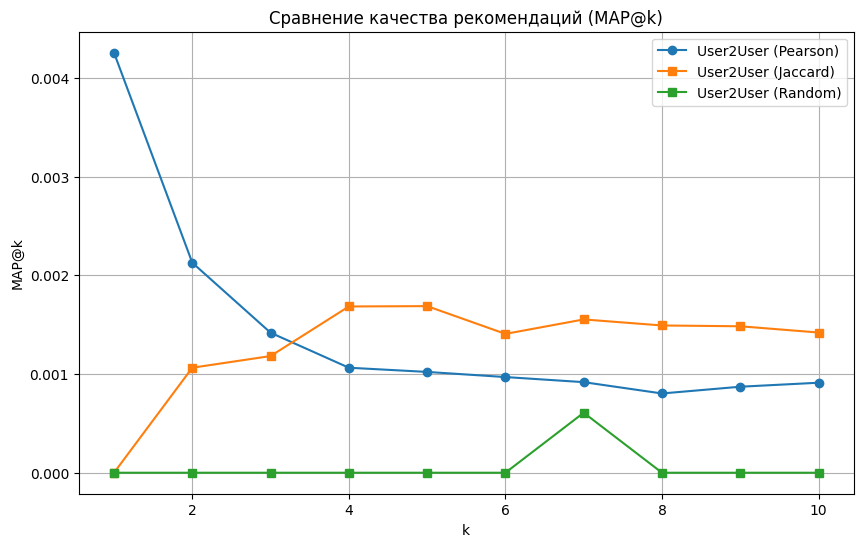

In [95]:
k_values = [1,2,3,4, 5,6,7,8,9, 10]

map_pearson = []
map_jaccard = []
map_random = []

model_pearson = User2User(train_ratings, pearson)
model_jaccard = User2User(train_ratings, jaccard)

N = model_pearson.n_users
all_items = list(range(model_pearson.n_items))

for k in k_values:
    recomends_pearson = model_pearson.get_test_recommendations(k)
    recomends_jaccard = model_jaccard.get_test_recommendations(k)

    recomends_random = []
    for _ in range(N):
        recomends_random.append(sample(all_items, k))

    map_p = mapk(test_relevant, recomends_pearson, k)
    map_j = mapk(test_relevant, recomends_jaccard, k)
    map_r = mapk(test_relevant, recomends_random, k)

    map_pearson.append(map_p)
    map_jaccard.append(map_j)
    map_random.append(map_r)

plt.figure(figsize=(10, 6))
plt.plot(k_values, map_pearson, marker='o', label='User2User (Pearson)')
plt.plot(k_values, map_jaccard, marker='s', label='User2User (Jaccard)')
plt.plot(k_values, map_random, marker='s', label='User2User (Random)')

plt.xlabel('k')
plt.ylabel('MAP@k')
plt.title('Сравнение качества рекомендаций (MAP@k)')
plt.legend()
plt.grid(True)
plt.show()

**Задание 6 (1.5 балла).** Как вы могли заметить, матрица оценок получается очень разреженной, но мы работаем с ней как с обычной, это не дело. Перепишите код так, чтобы все методы могли работать с разреженными матрицами и сравните скорость работы такого подхода с оригинальным.

In [18]:
from scipy.sparse import csr_matrix
import time

In [19]:
start = time.time()
model_dense = User2User(ratings, similarity_func=jaccard)
model_dense.get_test_recommendations(k=10)
print("Base time:", time.time() - start)

<ipython-input-16-4174750657>:25: RuntimeWarning: invalid value encountered in divide
  return numerator/denominator
<ipython-input-14-1291939530>:26: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]


Base time: 27.88586401939392


In [22]:
class User2User(BaseModel):
    def __init__(self, ratings, similarity_func):
        super().__init__(ratings)

        assert similarity_func in [pearson, jaccard]

        self.similarity_func = similarity_func
        self.alpha = 0.02
        self.R = csr_matrix(self.R)

    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        """
        # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        user_vector = user_vector.toarray()
        # print(self.R.shape)
        # print(user_vector.shape)
        scores = np.asarray(self.similarity_func(self.R,user_vector)).squeeze()

        mask = scores>self.alpha
        scores = scores[mask]

        numerator = scores @ self.R[mask]
        denominator = np.sum(scores)

        return numerator/denominator

    def recommend(self, uid: int):
        # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        user_vector = self.R[uid]
        similarities = self.similarity(user_vector)

        return np.argsort(similarities)[::-1]

In [23]:
start = time.time()
model = User2User(ratings, similarity_func=jaccard)
model.get_test_recommendations(k=20)
print("Sparse time:", time.time() - start)

<ipython-input-22-2680256340>:27: RuntimeWarning: invalid value encountered in divide
  return numerator/denominator
<ipython-input-14-1291939530>:26: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]


Sparse time: 17.085075616836548


Мы можем посмотреть глазами, насколько хорошо модель рекомендует треки. Для этого сравним уже прослушанные треки с рекомендованными и релевантными для случайного пользователя. Хорошо ли у вас получилось?

In [24]:
user_id = np.random.randint(0, model.n_users)

In [25]:
listened_tracks = train_ratings[train_ratings.userId == user_id].trackId[:15]

print('Already listened tracks:')

tracks_info.loc[listened_tracks][['name', 'artists']]

Already listened tracks:


,name,artists
27054,Обнажённый кайф,['TARAS']
31891,Лирика,"['Filatov & Karas', 'Masha']"
34447,Когда мы были молодыми,"['Руки Вверх!', 'Astero']"
37635,Обійми,['Океан Ельзи']
39131,Зая,['Бамбинтон']
39967,Cybernetic,['CRASPORE']
40213,Я хочу,['Grivina']
40620,Мало,['Grivina']
42913,Полетаем,['Raim & Artur']
43994,In My Mind,['Natalie Summer']


In [26]:
preds = model.get_test_recommendations(15)

print('Predicted tracks:')

tracks_info.loc[preds[user_id]][['name', 'artists']]

<ipython-input-22-2680256340>:27: RuntimeWarning: invalid value encountered in divide
  return numerator/denominator
<ipython-input-14-1291939530>:26: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]


Predicted tracks:


,name,artists
24124,Лифт,['Ассаи']
24125,Цветок,"['Ассаи', 'Manizha']"
24126,Река,"['Ассаи', 'Иван Дорн']"
24127,Моя королева,['T1One']
24128,Ещё до старта далеко,"['Тимати', ""L'One"", 'Павел Мурашов']"
24129,Lydia,['Highly Suspect']
24130,Soft Tenderness,['Miko Dowolla']
0,What There Is,['a-ha']
24132,Dynasty,['Miia']
24133,See You Again (feat. Bea Miller),"['Boyce Avenue', 'Bea Miller']"


In [27]:
test_tracks = test_ratings[test_ratings.userId == user_id].trackId[:15]

print('Test-time tracks:')

tracks_info.loc[test_tracks][['name', 'artists']]

Test-time tracks:


,name,artists
62155,Why Is There So Many Hot / Goodbye,"['Eduardo Luzquiños', 'Uravnobeshen Dikiy']"
62447,Such a Whore,['Jvla']
62565,Карабах,['SHAMI']
62773,В первый раз (cover),['Kamik']
62774,А если это любовь (cover),['Kamik']
62843,Я тебе поставлю лайк,['Бэтси']
62888,Deli Gibi,"['Otilia', 'Paw Jar']"
62992,Юность,['Dabro']
63000,Медляк,"['Мари Краймбрери', 'HammAli']"
63002,You Spin Me Round (Like A Record),"['Standy', 'Marc Korn']"


Ну судя по наличию AC/DC в конце рекомендаций, модель получилась не очень, потому что данный пользователь как-будто не слушает подобных исполнителей.

### Часть 2. Модель со скрытыми переменными

В этой части мы пощупаем метод рекомендаций со скрытыми переменными.
Идея: будем предсказывать оценки по формуле
$$
\hat{r}_{ui} = \langle p_u, q_u \rangle,
$$
$p_u \in \mathbb{R}^d$ и $q_i \in \mathbb{R}^d$ - латентные векторы пользователя $u$ и объекта $i$ соответственно.

Оптимизировать мы будем MSE между истинной оценкой пользователя и предсказанной с регуляризацией
$$
L = \sum_{(u, i) \in R} (\hat{r}_{ui} - r_{ui})^2 + \lambda \left(\sum_{u \in U} \|p_u\|^2 + \sum_{i \in I} \|q_i\|^2\right)
$$

**Задание 7 (1.5 балла).** На лекции рассматривались два подхода к оптимизации параметров. Можно это делать обычным стохастческим градинтным спуском, а можно по очереди обновлять матрицы $P, Q$, и тогда получится метод Alternating Least Squares (ALS). Вспомните формулы обновления и поясните их:

**SGD:** В данном методе просто идём по градиенту функций для каждого вектора

Обновление $p_{uk}$: $$p_{uk} = p_{uk} + \eta q_{ik}(r_{ui} - \langle p_u, q_i \rangle)-\eta\lambda p_{uk}$$
Обнолвение $q_{ik}$: $$p_{uk} = q_{ik} + \eta p_{uk}(r_{ui} - \langle p_u, q_i \rangle)-\eta\lambda q_{ik}$$


**ALS:**  По очереди фиксируем P и Q, тогда функционал будет выпуклым, и по нему ищем оптимальные параметры

Обновление $p_{u}$: $$p_{u} = (\sum_{i: ∃r_{ui}} (\langle q_i, q_i \rangle + λ))^{-1}\sum_{i: ∃r_{ui}} (r_{ui}q_i)$$

Обнолвение $q_{i}$: $$q_{i} = (\sum_{u: ∃r_{ui}} (\langle p_u, p_u \rangle + λ))^{-1}\sum_{u: ∃r_{ui}} (r_{ui}p_u)$$

**P.S.** Это знание с МО2, не уверен, что на лекциях ИАДА было так же

**Задание 8 (2 балла).** А теперь реализуйте методы оптимизации параметров для обоих алгоритмов.

In [46]:
class HiddenVars(BaseModel):
    def __init__(self, ratings, dim=128, mode='sgd'):
        super().__init__(ratings)
        self.dim = dim

        assert mode in ['sgd', 'als']
        self.mode = mode

        self.P = np.random.normal(size=(self.n_users, dim))
        self.Q = np.random.normal(size=(self.n_items, dim))

        self.lr = 0.0003
        self.lamb = 0.01

        self.R = csr_matrix(self.R)

    def fit(self, num_iters=5):
        for epoch in tqdm(range(num_iters)):

            if self.mode == 'sgd':
                # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
                rows, cols = self.R.nonzero()
                for u, i in zip(rows, cols):
                    r_ui = self.R[u, i]

                    pred = self.P[u] @ self.Q[i]
                    err = r_ui - pred

                    self.P[u] += self.lr * (err * self.Q[i] - self.lamb * self.P[u])
                    self.Q[i] += self.lr * (err * self.P[u] - self.lamb * self.Q[i])

            elif self.mode == 'als':
                # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
                R = self.R.tocsr()

                for u in range(self.n_users):
                    item_ids = R[u].indices
                    Q_i = self.Q[item_ids]
                    r_u = R[u, item_ids].toarray().flatten()

                    A = Q_i.T @ Q_i + self.lamb * np.eye(self.dim)
                    b = Q_i.T @ r_u
                    self.P[u] = np.linalg.solve(A, b) # типо вместо поиска обратной матрицы

                R_T = self.R.T.tocsr()

                for i in range(self.n_items):
                    user_ids = R_T[i].indices
                    P_u = self.P[user_ids]
                    r_i = R_T[i, user_ids].toarray().flatten()

                    A = P_u.T @ P_u + self.lamb * np.eye(self.dim)
                    b = P_u.T @ r_i
                    self.Q[i] = np.linalg.solve(A, b)

    def recommend(self, uid):
        pred_rating = self.P[uid] @ self.Q.T

        return np.argsort(pred_rating)[::-1]

**Задание 9 (1 балл).** Для обоих алгоритмов подберите оптимальные значения размерности скрытого пространства $d$ и размера предсказания $k$. Как изменяется качество предсказаний с числом итераций обучения? Постройте соответствующие графики, сравните со случайным подхом и User2User, сделайте выводы. Какой алгоритм вам кажется более подходящим для данной задачи и почему?

P.S. Хотя бы один из методов обучения должен приводить к лучшим результатам в сравнении с User2User подходом.

P.P.S. Методу LFM свойственно переобучаться, поэтому при подборе параметров полезно смотреть на значения ошибки и оптимизируемой метрики на тренировочном датасете. Вы также можете менять начальную инициализацию и прочие параметры, за исключением архитектуры, на ваш вкус.

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

<ipython-input-14-1291939530>:26: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

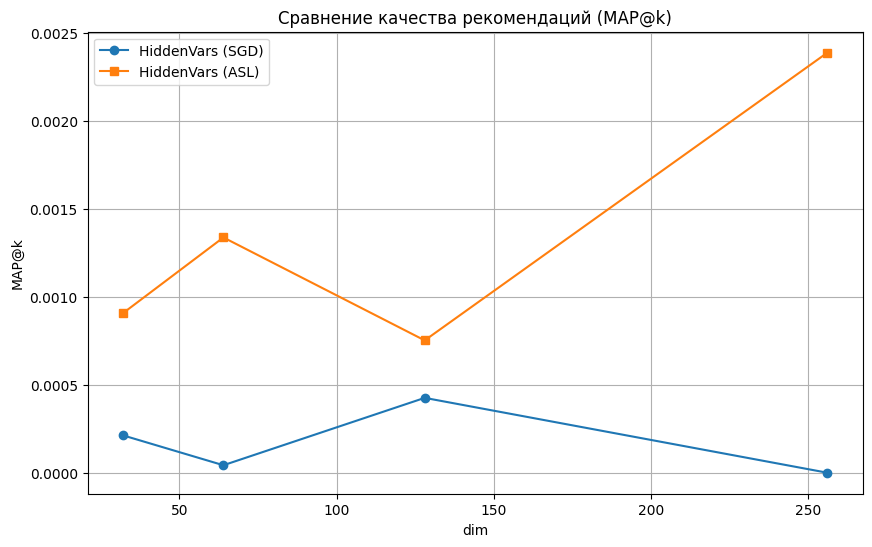

In [48]:
dim_values = [32,64,128,256]

k = 10

map_sgd = []
map_asl = []

for dim in dim_values:
    model_sgd = HiddenVars(train_ratings, dim, 'sgd')
    model_asl = HiddenVars(train_ratings, dim, 'als')

    model_sgd.fit(num_iters=1)
    model_asl.fit(num_iters=1)

    recomends_sgd = model_sgd.get_test_recommendations(k)
    recomends_asl = model_asl.get_test_recommendations(k)

    mapk_sgd = mapk(test_relevant, recomends_sgd, k)
    mapk_asl = mapk(test_relevant, recomends_asl, k)

    map_sgd.append(mapk_sgd)
    map_asl.append(mapk_asl)

plt.figure(figsize=(10, 6))
plt.plot(dim_values, map_sgd, marker='o', label='HiddenVars (SGD)')
plt.plot(dim_values, map_asl, marker='s', label='HiddenVars (ASL)')

plt.xlabel('dim')
plt.ylabel('MAP@k')
plt.title('Сравнение качества рекомендаций (MAP@k)')
plt.legend()
plt.grid(True)
plt.show()

  0%|          | 0/5 [00:00<?, ?it/s]

<ipython-input-14-1291939530>:26: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

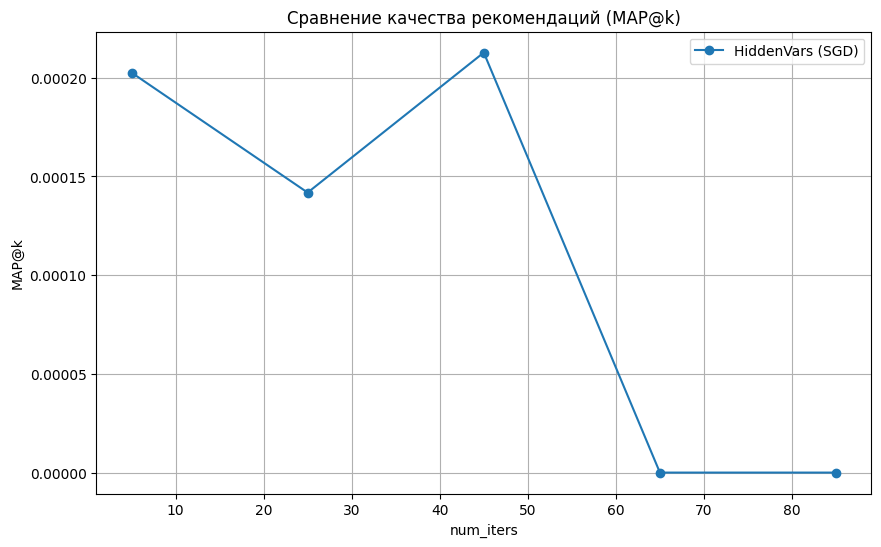

In [51]:
num_iters_values = np.arange(5, 100, 20)
dim = 128
k = 10

map_sgd = []

for num_iters in num_iters_values:
    model_sgd = HiddenVars(train_ratings, dim, 'sgd')

    model_sgd.fit(num_iters=num_iters)

    recomends_sgd = model_sgd.get_test_recommendations(k)

    mapk_sgd = mapk(test_relevant, recomends_sgd, k)

    map_sgd.append(mapk_sgd)

plt.figure(figsize=(10, 6))
plt.plot(num_iters_values, map_sgd, marker='o', label='HiddenVars (SGD)')

plt.xlabel('num_iters')
plt.ylabel('MAP@k')
plt.title('Сравнение качества рекомендаций (MAP@k)')
plt.legend()
plt.grid(True)
plt.show()

  0%|          | 0/45 [00:00<?, ?it/s]

<ipython-input-14-1291939530>:26: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

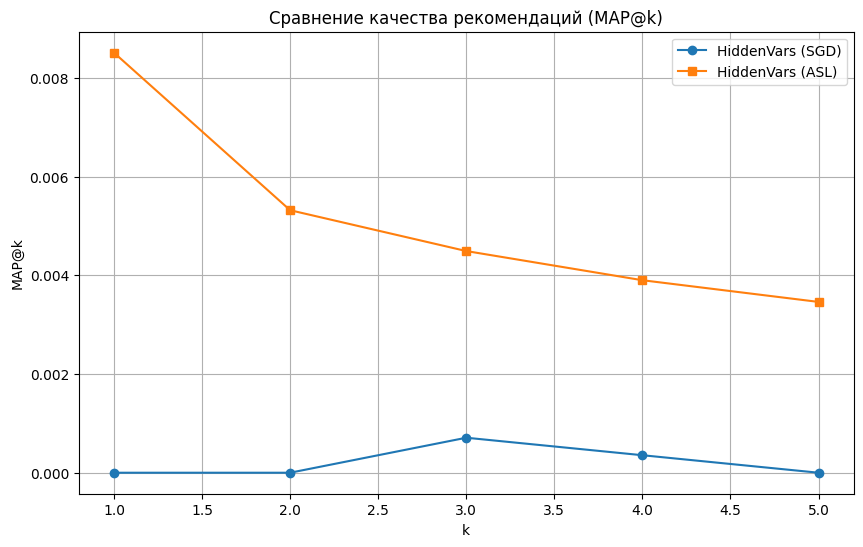

In [55]:
dim = 128
k_values = [1,2,3,4,5]

map_sgd = []
map_asl = []

for k in k_values:
    # model_sgd = HiddenVars(train_ratings, 256, 'sgd')
    # model_asl = HiddenVars(train_ratings, 256, 'als')
    model_sgd = HiddenVars(train_ratings, dim, 'sgd')

    model_sgd.fit(num_iters=25)

    recomends_sgd = model_sgd.get_test_recommendations(k)
    recomends_asl = model_asl.get_test_recommendations(k)

    mapk_sgd = mapk(test_relevant, recomends_sgd, k)
    mapk_asl = mapk(test_relevant, recomends_asl, k)

    map_sgd.append(mapk_sgd)
    map_asl.append(mapk_asl)

plt.figure(figsize=(10, 6))
plt.plot(k_values, map_sgd, marker='o', label='HiddenVars (SGD)')
plt.plot(k_values, map_asl, marker='s', label='HiddenVars (ASL)')

plt.xlabel('k')
plt.ylabel('MAP@k')
plt.title('Сравнение качества рекомендаций (MAP@k)')
plt.legend()
plt.grid(True)
plt.show()

Ну будем считать, что я попытался нормально подобрать гиперпараметры, но на ALS это было нереально сделать (ну какие 14 минут на 1 итерацию при эмбеддинге 512). С SGD вообще результаты вышли не очень, но тут наверное тоже я плохо гиперпараметры подобрал. Но ALS в итоге перебила результат User2User.

Если у вас получилось достаточно хорошее качество, то при оптимизации параметров марицы $Q$ похожим трекам стали соответствовать похожие векторы. Поэтому мы можем для любого трека найти наиболее близкие к нему в латентном пространстве и проверить степерь обученности модели вручную.

In [57]:
model = model_asl

In [58]:
example_trackId = tracks_info[tracks_info.name == 'Выхода нет'].iloc[0].id

preds = model.Q @ model.Q[example_trackId]
preds = preds / np.sqrt((model.Q**2).sum(axis=1) + 1e-8)

track_idxs = preds.argsort()[::-1][:20]

In [59]:
similar_tracks = tracks_info.loc[track_idxs][['name', 'artists']]
similar_tracks['similarity'] = preds[track_idxs] / np.linalg.norm(model.Q[example_trackId])
similar_tracks

,name,artists,similarity
5512,Выхода нет,['Сплин'],1.000000
5570,Моё сердце,['Сплин'],0.720899
2058,Последний герой,['КИНО'],0.718202
16637,Zodiac,['Zodiac'],0.713547
5153,Stormbringer,['Deep Purple'],0.713547
9689,Bicycle Race,['Queen'],0.713547
17331,"Последнее письмо (Гудбай, Америка)",['Nautilus Pompilius'],0.682354
10714,Буги-вуги каждый день,['Зоопарк'],0.670353
44373,Do Your Worst,['Rival Sons'],0.670353
16635,Pacific,['Zodiac'],0.670353
